In [ ]:
!pip install haversine

In [1]:
import os
import math
import gym
from gym import spaces
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely import geometry
from shapely.geometry import LineString, Point
from utils import *
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 100)
from haversine import haversine, Unit

import warnings
warnings.filterwarnings('ignore')
%load_ext tensorboard


In [10]:
featurefile = pd.read_csv('featurefile_transformed_2.csv')
featurefile.head()


,Unnamed: 0,filenames,resolvedflight,flightstarttime_original_res,original_resstart_lat,original_resstart_lon,original_resend_lat,distfrombound_TCP,original_resend_lon,resflight_offset,flightstarttime_original_unres,original_unresstart_lat,original_unresstart_lon,original_unresend_lat,original_unresend_lon,unresflight_offset,initialhead_resolved,initialhead_unresolved,conflict_angle,mantoconflict_dunres,mantoconflict_dres,tcp_direction,unrsolvedflight_dirn,d_bound_manstart,d_bound_CPA,neighbouring_ac,meandistance,timetoresolution,d_resstart_CPA,headingAngle,crosstrack_dist_max,mergewp_name,mergept_TCPdist,resolved_ac,manstrt_time,manstrt_res_lon,mansrtr_res_lat,resflight_CPA_lon,resflight_CPA_lat,unresflight_CPA_lon,unresflight_CPA_lat,maxcrosstrack_time,maxcrosstrack_lon,maxcrosstrack_lat,mergept_time,mergept_lon,mergept_lat,CPA_orig_maneuvered,original_resstart_lat_T,original_resend_lat_T,original_unresstart_lat_T,original_unresend_lat_T,manstart_res_lat_T,maxcrosstrack_lat_T,original_resstart_lon_T,original_resend_lon_T,original_unresstart_lon_T,original_unresend_lon_T,manstart_res_lon_T,maxcrosstrack_lon_T,NAME,LAT,LON,lon_T,lat_T
0,0,170321set1_1_KL01.csv_1_3K00.csv,170321set1_1_KL01.csv,14:00:40,4.57262,106.403,2.50410,19.14,106.548,22,14:02:30,3.72198,107.306,1.60220,103.998,0,170,249,79.82,44.747429,48.740609,-1,-1,4.53,30.28,0,0.00,6.17,46,160,6.13,OMLIV,38.60,farther,14:04:30,106.245,4.14306,106.382,3.38520,106.382,3.38520,14:09:15,106.450,3.57772,14:14:20,106.469,2.93461,6.77,89.3155,37.60250,68.0495,15.05500,78.57650,64.44300,68.06,70.96,86.12,19.96,64.90,69.00,ONAPO,3.353889,106.387778,67.755556,58.847222
1,1,170321set1_1_SQ20.csv_1_QR21.csv,170321set1_1_SQ20.csv,14:14:40,3.72198,107.306,1.60220,21.03,103.998,77,14:21:05,2.52356,106.535,3.18297,104.142,0,249,286,36.36,59.616039,63.374070,-1,-1,37.54,19.74,1,92.54,8.08,61,210,13.65,WP071,78.58,farther,14:24:20,106.169,3.26591,105.220,2.90634,105.220,2.90634,14:27:25,105.955,2.94447,14:37:45,104.670,2.69183,11.12,68.0495,15.05500,38.0890,54.57425,56.64775,48.61175,86.12,19.96,70.70,22.84,63.38,59.10,LIPRO,2.895000,105.190833,43.816667,47.375000
2,2,170321set1_1_QR31.csv_1_3K30.csv,170321set1_1_QR31.csv,14:21:55,3.72198,107.306,3.40823,21.62,103.908,37,14:25:00,4.57262,106.403,2.56699,104.093,0,267,231,36.20,43.565178,49.890922,1,1,36.23,24.73,3,57.40,6.08,46,330,12.32,VISAT,79.24,farther,14:32:15,106.029,3.51914,105.269,3.47690,105.269,3.47690,14:34:30,105.837,3.71123,14:44:55,104.544,3.44267,15.09,68.0495,60.20575,89.3155,39.17475,62.97850,67.78075,86.12,18.16,68.06,21.86,60.58,56.74,MABAL,3.473889,105.209722,44.194444,61.847222
3,3,170321set1_1_KL41.csv_1_TR40.csv,170321set1_1_KL41.csv,14:29:40,4.57262,106.403,2.50410,31.44,106.548,0,14:28:55,4.19994,105.012,2.35462,107.115,9,170,131,37.29,66.980781,60.068521,1,1,13.24,10.51,4,78.15,8.33,62,230,18.20,OMLIV,48.69,closer,14:35:30,106.280,3.89266,106.480,2.86689,106.480,2.86689,14:38:35,106.032,3.60852,14:45:00,106.466,2.92278,6.07,89.3155,37.60250,79.9985,33.86550,72.31650,65.21300,68.06,70.96,40.24,82.30,65.60,60.64,OMLIV,2.919722,106.469722,69.394444,47.993056
4,4,170321set1_1_GA50.csv_1_3K51.csv,170321set1_1_GA50.csv,14:35:10,3.72198,107.306,1.60220,21.36,103.998,83,14:42:05,2.52356,106.535,3.18297,104.142,0,249,286,36.36,57.068835,57.016036,-1,-1,36.44,18.66,3,70.06,7.50,56,210,12.45,WP071,73.51,closer,14:45:40,106.070,3.22811,105.191,2.89499,105.191,2.89499,14:48:30,105.872,2.93408,14:58:10,104.671,2.69216,6.84,68.0495,15.05500,38.0890,54.57425,55.70275,48.35200,86.12,19.96,70.70,22.84,61.40,57.44,LIPRO,2.895000,105.190833,43.816667,47.375000


In [4]:
delta_heading = featurefile['initialhead_resolved'] - featurefile['headingAngle']
delta_heading.unique()

array([ 10,  39, -63, -60, -19,  31,  29, -33,  59,  41, -70, -29,  -9,
        20,  19, -39, -80,  51,   9,  61, -53, -40, -14, -50,  30,  49,
       -73, -89, -59, -44, -43, -30, -90,  50])

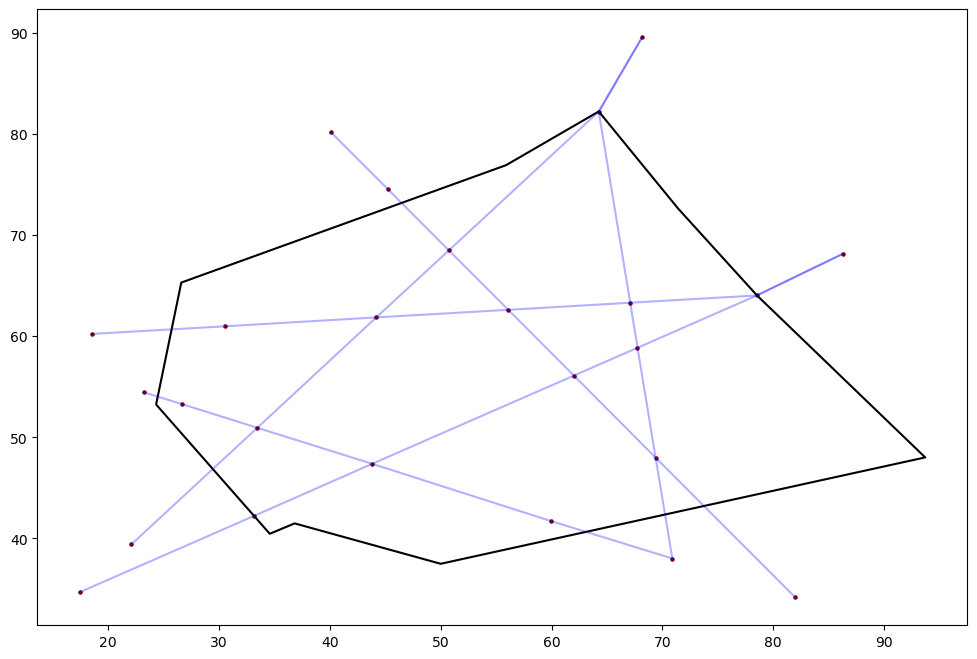

In [6]:
a = plot_sector()

class Ownship:
    def __init__(self, start_x, start_y, heading, speed, offset, original_path, destination):
        self.start_x = start_x
        self.start_y = start_y
        self.x = start_x
        self.y = start_y
        self.offset = offset
        self.heading = heading
        self.speed = speed
        self.offset = offset
        self.destination = destination
        self.pathlist = []
        self.original_path = original_path
        self.position = [self.x, self.y]

    def step(self, n_step, new_heading):
        if n_step <= self.offset:
            self.x = self.start_x
            self.y = self.start_y
        else:    
            self.heading = new_heading
            self.x = np.clip(self.x + self.speed *np.cos(new_heading), 0, 100)
            self.y = np.clip(self.y + self.speed *np.sin(new_heading), 0, 100)
        return self.x, self.y
    
class Intruder:
    def __init__(self, start_x, start_y, offset, heading, speed, destination):
        self.start_x = start_x
        self.stat_y = start_y
        self.x = start_x
        self.y = start_y
        self.offset = offset
        self.heading = heading
        self.speed = speed
        self.destination = destination
        self.position = [self.x, self.y]

    def step(self, n_step, new_heading):
        if n_step <= self.offset:
            self.x = self.start_x
            self.y = self.start_y
        else:
            self.heading = new_heading
            self.x = np.clip(self.x + self.speed *np.cos(new_heading), 0, 100)
            self.y = np.clip(self.y + self.speed *np.sin(new_heading), 0, 100)
        return self.x, self.y


In [79]:
class Agent():
    def __init__(self):
        o_resolved_path, o_unres_path, o_heading, o_startposition, o_offset_dist_scaled, o_destination, \
        i_path, i_heading, i_startposition, i_offset_dist_scaled, i_destination, fileinfo = get_conflict_scenario(featurefile)

        self.o_resolved_path = o_resolved_path
        self.o_unresolved_path = o_unres_path
        self.o_initial_heading = o_heading
        self.o_heading = o_heading
        self.o_start = tuple(o_startposition)
        self.o_position = o_startposition
        self.o_offset_dist = o_offset_dist_scaled
        self.o_destination = o_destination
        self.o_newpathlist = [self.o_position]
        self.ATCO_path_linestring = LineString(o_resolved_path)
        self.i_heading = i_heading
        self.i_start = tuple(i_startposition)
        self.i_position = i_startposition
        self.i_path = i_path
        self.i_offset_dist = i_offset_dist_scaled
        self.i_destination = i_destination
        self.o_speed = 2.5
        self.i_speed = 2.5
        self.o_offset = int(np.ceil(self.o_offset_dist/self.o_speed))
        self.i_offset = int(np.ceil(self.i_offset_dist/self.i_speed))

        self.fileinfo = fileinfo
        # print(self.o_offset, self.i_offset)


    def step(self, n_step, new_heading):
        xo, yo, xi, yi = 0, 0, 0, 0
        if n_step <= self.i_offset:
            self.o_position = self.o_start
        else:    
            self.o_heading = new_heading
            xo = np.clip(self.o_position[0] + self.o_speed *np.cos(new_heading), 15, 100)
            yo = np.clip(self.o_position[1] + self.o_speed *np.sin(new_heading), 15, 100)
            # xo = self.o_unresolved_path[n_step - self.i_offset][0]
            # yo = self.o_unresolved_path[n_step - self.i_offset][1]
            self.o_position = [xo,yo]

        self.o_newpathlist.append([xo,yo])

        # print('offset',self.i_offset)  
        if n_step <= self.o_offset:
            self.i_position = self.i_start
        elif len(self.i_path)+ self.o_offset > n_step > self.o_offset:
            self.i_position = self.i_path[n_step - self.o_offset]
            # print("ok")
        # if (n_step - self.i_offset) >= len(self.i_path):
        #     self.i_position = self.i_destination
        else:
            self.i_position = self.i_destination


        return self.o_position, self.i_position

        

In [80]:
A = Agent()


In [81]:
class StructuredEnv(gym.Env):
    SAFE_R = 5
    MAX_STEP = 60

    def __init__(self, Reward_Params= [-1, -1, -1, -1, -1, 1]):
        self.Reward_Params = Reward_Params
        self.agent = Agent()
        self.reward = 0
        self.n_step = 0
        self.total_reward = 0
        n_observations = np.size(self.observation_func())
        self.action_space = spaces.Discrete(13)       
        self.observation_space = spaces.Box(low = -100, high = 120, shape= (n_observations, ), dtype = np.float64)

    def reset(self):
        self.agent = Agent()
        self.reward = 0
        self.n_step = 0
        self.total_reward = 0
        observation = self.observation_func()
        
        return observation

    def step(self, action):
        self.n_step += 1

        ownship_heading = self.agent.o_heading
        # print(ownship_heading)
        if action < 7:
            angle = action * (0.175/2) # this is radians ( when using slope it is 0.056)
        else:
            angle = (action - 6) * -(0.175/2) # -5 deg;  if action == 8; angle = (8-6) *-10 = -20 deg: this kind of mapping

        # anngle = 0
        ownship_heading = ownship_heading + angle
        # print(ownship_heading)
    
        self.agent.step(self.n_step, ownship_heading) # new location for ownship
            

        self.done  = self.check_stopping_condition()
        self.reward = self.reward_func( self.done)
        observation = self.observation_func()
        self.total_reward += self.reward

        info = {}
        return observation, self.reward, self.done, info
    
    def check_stopping_condition(self):
        done = False
        p1 = self.agent.o_position
        o_destination = self.agent.o_destination
        p2 = self.agent.i_position
        i_destination = self.agent.i_destination

        dist1 = np.linalg.norm(np.array(p1) - np.array(o_destination))
        dist2 = np.linalg.norm(np.array(p2) - np.array(i_destination))
        if (dist1 < 2) and dist2 < 2: # reaching deatinations
            return True
        if self.n_step >= self.MAX_STEP:
            return True          

        sep_dist = np.linalg.norm(np.array(p1) - np.array(p2))
        if (sep_dist < self.SAFE_R): # LOS
            return True
        
        #moving back termination
        threshold = 0.1
        if len(self.agent.o_newpathlist) <=2:
            pass
        else:
            previous_location = np.array(self.agent.o_newpathlist[-2])
            o_current_location = np.array(self.agent.o_position)

            prev_distance = np.linalg.norm(o_destination - previous_location)
            current_distance = np.linalg.norm(o_destination - o_current_location)

            if prev_distance - current_distance < -threshold:
                return True
        
        return False

            
    def reward_func(self, done):
        """ 
        Reward = a1 * Reward_Step (-ve) +         
                 a2 * Reward_Deviation (-ve) + 
                 a3 * Reward_LOS (-ve) + 
                 a4 * Reward_Maneuvering(-ve) + 
                 a5 * Reward_Not_Reached (-ve)+ 
                 a6 * Reward_Reached (+ve)
        """        
        a1 = self.Reward_Params[0]
        a2 = self.Reward_Params[1]
        a3 = self.Reward_Params[2]
        a4 = self.Reward_Params[3]
        a5 = self.Reward_Params[4]
        a6 = self.Reward_Params[5]
        
        ####################

        Reward_Step = 0.01
        Moving_back_reward = 0
        CTDreward = 0
        reward_traj_dev = 0

        original_path_unmaneuvered_string = LineString(self.agent.o_unresolved_path)
        o_current_location = Point(self.agent.o_position)
        i_current_location = Point(self.agent.i_position)

        CTD_distance  = o_current_location.distance(original_path_unmaneuvered_string)

        CTDreward = 2* (CTD_distance/1000)

      
        o_destination = np.array(self.agent.o_destination)
        i_destination = np.array(self.agent.i_destination)
        

        o_current_location = Point(self.agent.o_position)
        ATCO_path_linestring = self.agent.ATCO_path_linestring
        dist = o_current_location.distance(ATCO_path_linestring)/1000
        reward_traj_dev =  2* dist

        Reward_Deviation = CTDreward +  reward_traj_dev

              
        Reward_LOS = 0
        Reward_Maneuvering = 0
        Reward_Not_Reached = 0
        Reward_Reached =0
        
        # Distance between two aircraft for Loss-of-Separation constraint
        dis1 = np.linalg.norm(np.array(self.agent.o_position) - np.array(self.agent.i_position))
        
        Reward_LOS = 0
        threshold = 0.1
        if done:
            if (dis1 < self.SAFE_R) :
                Reward_LOS = 10

            if self.n_step == self.MAX_STEP:
                current_location = self.agent.o_position
                dist_o_d = np.linalg.norm(np.array(o_destination) - np.array(current_location))
                # dist_i = np.linalg.norm(i_destination - current_location) NOT ADDING i since there is no  learning per say

                Reward_Not_Reached = 1.2*(dist_o_d/100)

            if len(self.agent.o_newpathlist) <=2:
                pass
            else:
                previous_location = np.array(self.agent.o_newpathlist[-2])
                o_current_location = np.array(self.agent.o_position)

                prev_distance = np.linalg.norm(o_destination - previous_location)
                current_distance = np.linalg.norm(o_destination - o_current_location)

                if prev_distance - current_distance < -threshold:
                    Moving_back_reward =  -5 
               

            #reaching destination
            p1 = self.agent.o_position
            o_destination = self.agent.o_destination
            p2 = self.agent.i_position
            i_destination = self.agent.i_destination
            dist1 = np.linalg.norm(np.array(p1) - np.array(o_destination))
            # dist2 = np.linalg.norm(np.array(p2) - np.array(i_destination))
            if (dist1 < 2): # reaching deatination
                Reward_Reached = 5

        reward = a1 * Reward_Step + a2 *Reward_Deviation + a3 * Reward_LOS + a4 * Reward_Maneuvering + \
                    a5 * Reward_Not_Reached + a6 * Reward_Reached + Moving_back_reward
        return reward        


    def observation_func(self):
        observation  = []

        observation.append(self.agent.o_position[0])
        observation.append(self.agent.o_position[1])
        observation.append(self.agent.i_position[0])
        observation.append(self.agent.i_position[0])
        observation.append(self.agent.o_destination[0])
        observation.append(self.agent.o_destination[1])
        observation.append(self.agent.i_destination[0])
        observation.append(self.agent.i_destination[1])
    

        dist1 = np.linalg.norm(np.array(self.agent.o_position) - np.array(self.agent.i_position)) 
        dist_o_d = np.linalg.norm(np.array(self.agent.o_position) - np.array(self.agent.o_destination))
        dist_i_d = np.linalg.norm(np.array(self.agent.i_position) - np.array(self.agent.i_destination))

        observation.append(dist1)
        observation.append(dist_o_d)
        observation.append(dist_i_d)
        # individual coordinates


        current_location = Point(self.agent.o_position)
        CTD_distance  = current_location.distance(LineString(self.agent.o_unresolved_path))
        dist_from_ATCO_path = current_location.distance(self.agent.ATCO_path_linestring)

        observation.append(CTD_distance) # dist of ownship from the original path
        observation.append(dist_from_ATCO_path)

        observation.append(self.agent.o_heading)     

        observation = np.array(observation)
        return observation

   
    def render(self, show = False, folder = './Images/'):
        # fig, ax = plt.subplots(figsize = (14, 11))
        # print("Ownship", self.agent.o_start)
        # print("intruder", self.agent.i_start)
        # print(self.agent.fileinfo)

        figure = plot_sector()
        ax = figure.gca()
        # ax.scatter(50,50, s = 200)
        ax.scatter(self.agent.o_position[0], self.agent.o_position[1], c = 'black', s = 40)
        ax.scatter(self.agent.o_start[0], self.agent.o_start[1] , c = 'black', s = 50, marker = '^')
        ax.scatter(self.agent.o_destination[0], self.agent.o_destination[1], c = 'black', s = 20, marker= '*')

        ax.scatter(self.agent.i_position[0], self.agent.i_position[1], c = 'maroon', s = 40)
        ax.scatter(self.agent.i_start[0], self.agent.i_start[1] , c = 'maroon', s = 50, marker = '^')
        ax.scatter(self.agent.i_destination[0], self.agent.i_destination[1], c = 'maroon', s = 20, marker= '*')
        x, y = [],[]
        for i in range(len(self.agent.o_unresolved_path)):
            x.append(self.agent.o_unresolved_path[i][0])    
            y.append(self.agent.o_unresolved_path[i][1])
            
        # ax.plot(x,y, linewidth = 1, color = 'grey')
                   
        x_, y_ = self.agent.ATCO_path_linestring.xy
        ax.plot(x_, y_, color = 'maroon',linestyle = '--', alpha = 1)


            
        ax.set_title("Step {} - Reward {:.3f} - Total Reward {:.3f} - headings{}  - offsets(O:I){}".format(self.n_step,self.reward,\
                                                                            self.total_reward,\
                                                                                ((self.agent.o_initial_heading) ,\
                                                                                     np.round(math.degrees(self.agent.o_heading),2)),\
                                                                                        (self.agent.o_offset, self.agent.i_offset)))

        # ax.axis('scaled')

        if show:
            plt.show()
        else:
            plt.savefig(folder + "image_{:0>3}.png".format(self.n_step)) 
            print(folder + "image_{:0>3}.png".format(self.n_step))

        return figure

    def close(self):
        pass
            
    



In [82]:
from stable_baselines3.common.env_checker import check_env
env = StructuredEnv()
check_env(env)

./Images/image_000.png


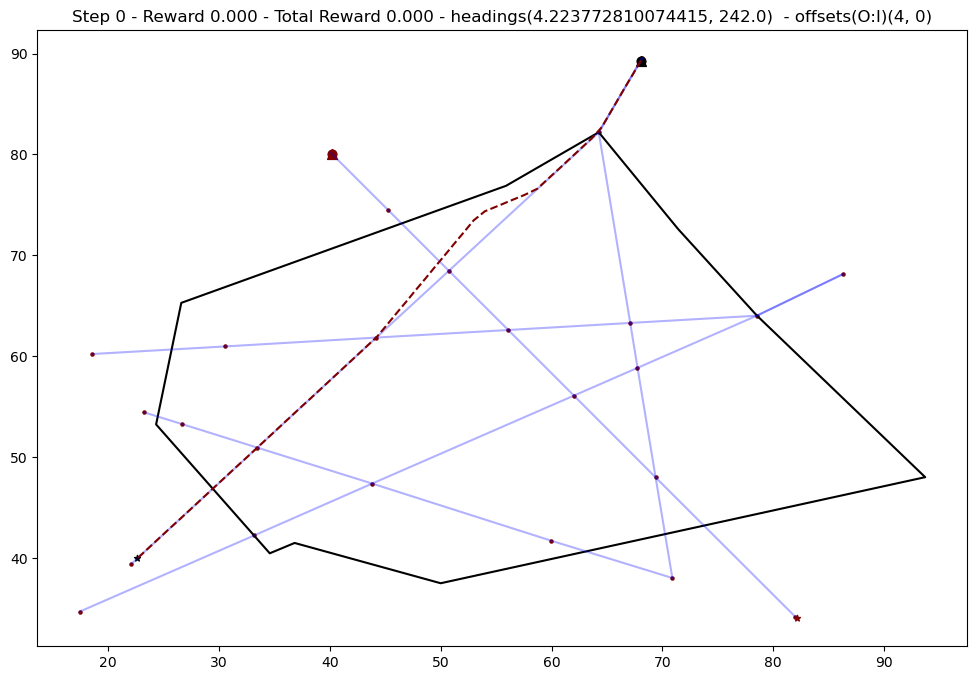

In [83]:
env.reset()
env.render()
env.close()


In [ ]:
env.observation_func()

In [ ]:
%tensorboard --logdir=./Log/CustomEnv/ --host=localhost --port=8030

In [84]:
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
import glob
from PIL import Image

In [85]:
name = 'env_PPO_4july'
Reward_Params= [-1, -1, -1, -1, -1, 1]



model = PPO(MlpPolicy, env ,gamma=0.99, tensorboard_log='./Log/CustomEnv/')
eval_env = env
eval_callback = EvalCallback(eval_env, best_model_save_path='./log/PPO/',
                             log_path='./log/PPO/', eval_freq=5000,
                             deterministic=True, render=False)
model.learn(total_timesteps= 2000000, tb_log_name=name, callback=eval_callback)
# model.learn(total_timesteps=1000000, tb_log_name=name)

# model.save("./Models/CustomEnv/" +name) 

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)

2023-07-11 11:03:04.180888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 11:03:04.212821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 11:03:04.880103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [35]:
model = PPO.load('./log/PPO/best_model.zip')


120321set1_1_KL281.csv 120321set1_1_TR280.csv
Offet distances 9.14690412919332 0.0
4 0
./images2/image_001.png
./images2/image_002.png
./images2/image_003.png
./images2/image_004.png
./images2/image_005.png
./images2/image_006.png
./images2/image_007.png
./images2/image_008.png
./images2/image_009.png
./images2/image_010.png
./images2/image_011.png
./images2/image_012.png
./images2/image_013.png
./images2/image_014.png
./images2/image_015.png
./images2/image_016.png
./images2/image_017.png
./images2/image_018.png
./images2/image_019.png
./images2/image_020.png
./images2/image_021.png
./images2/image_022.png
./images2/image_023.png
./images2/image_024.png
./images2/image_025.png
./images2/image_026.png
./images2/image_027.png


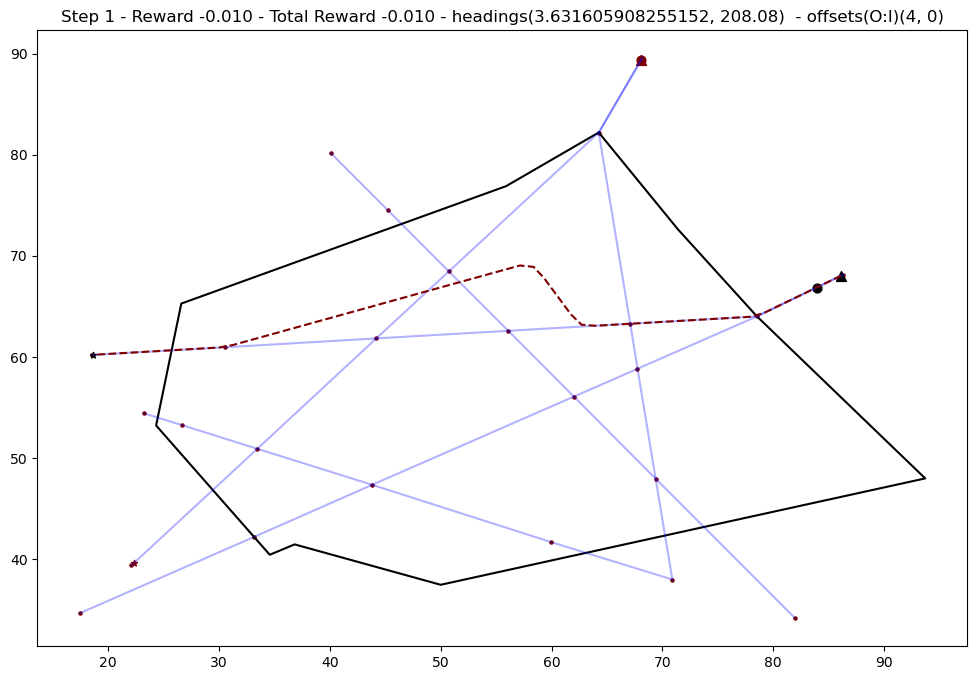

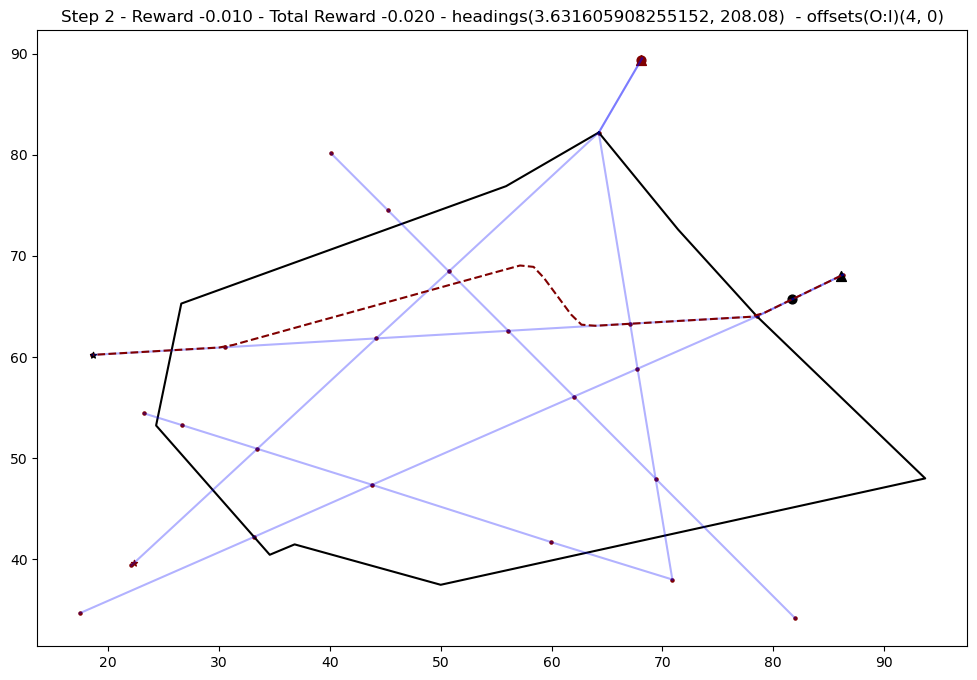

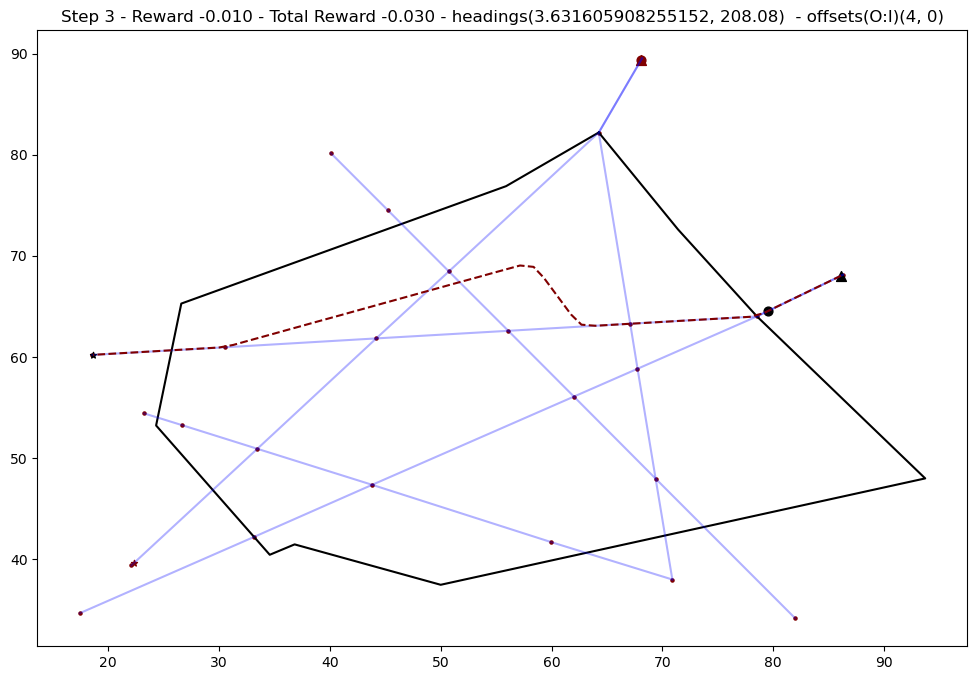

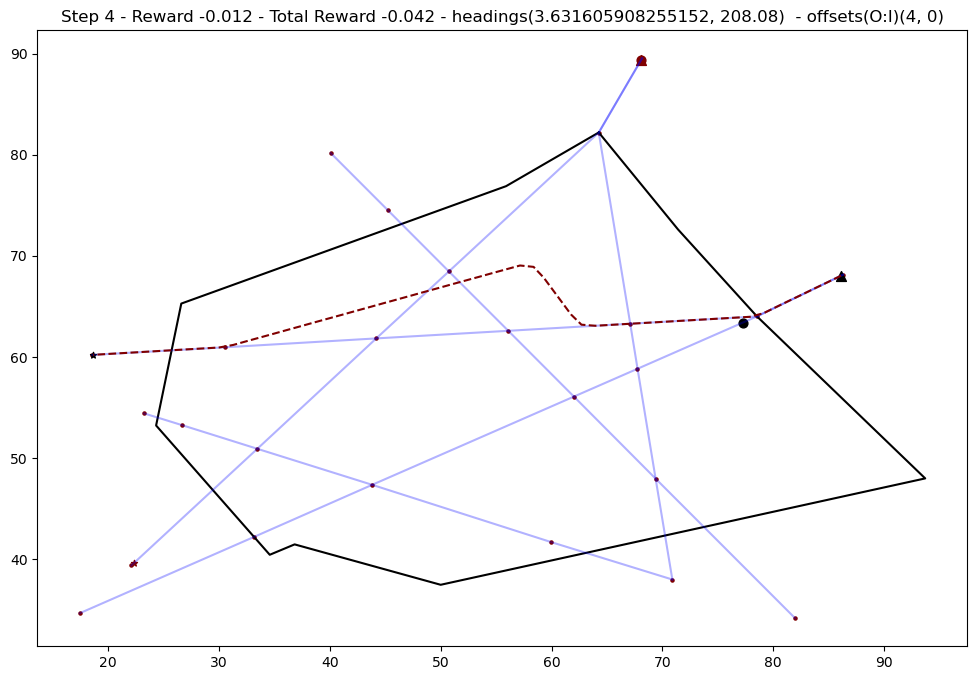

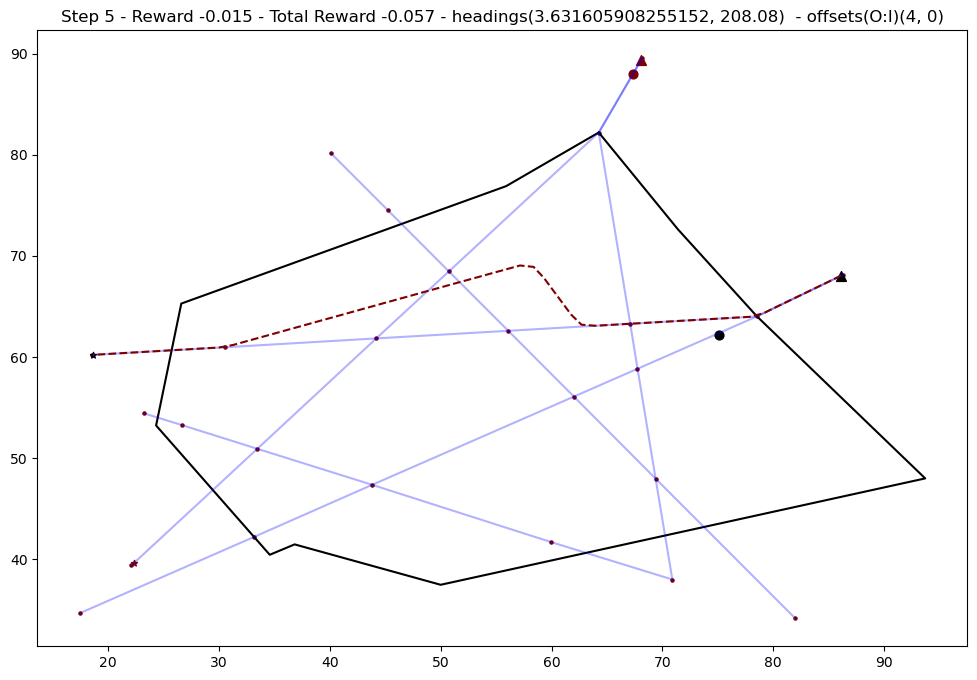

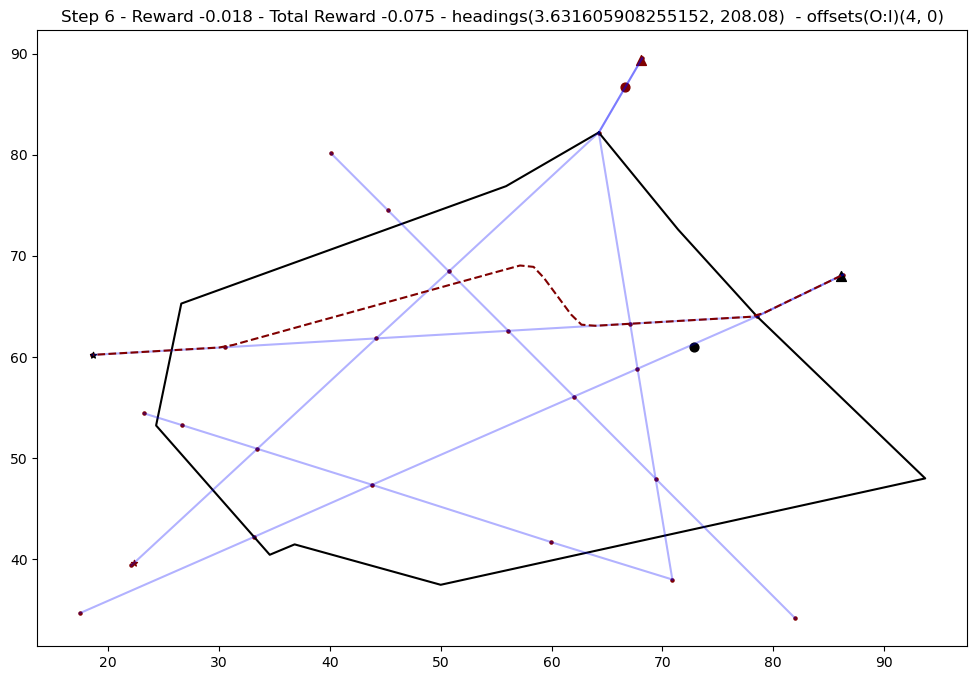

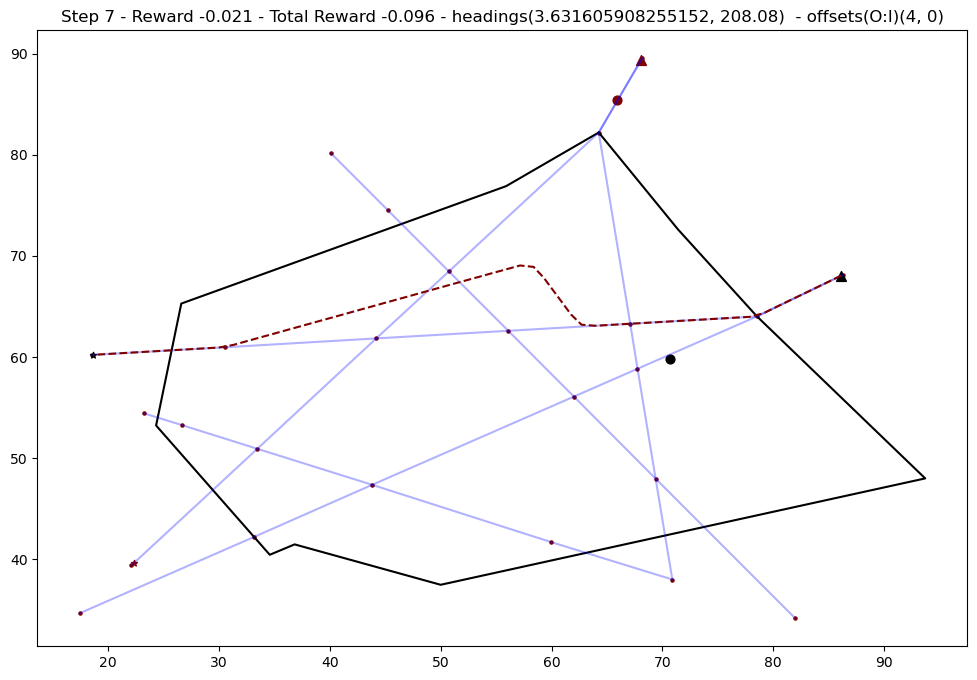

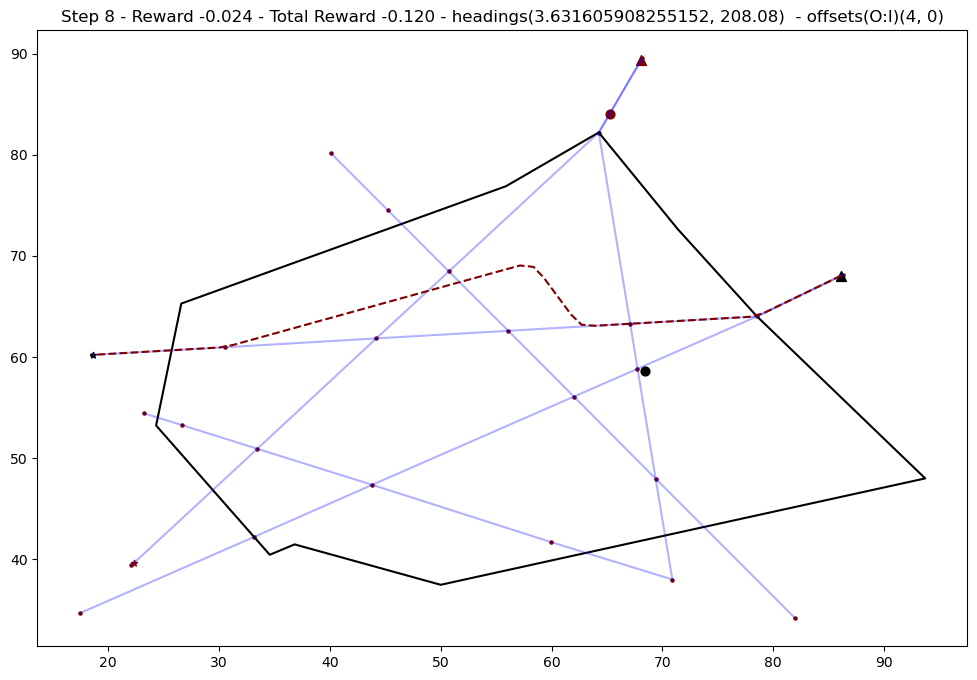

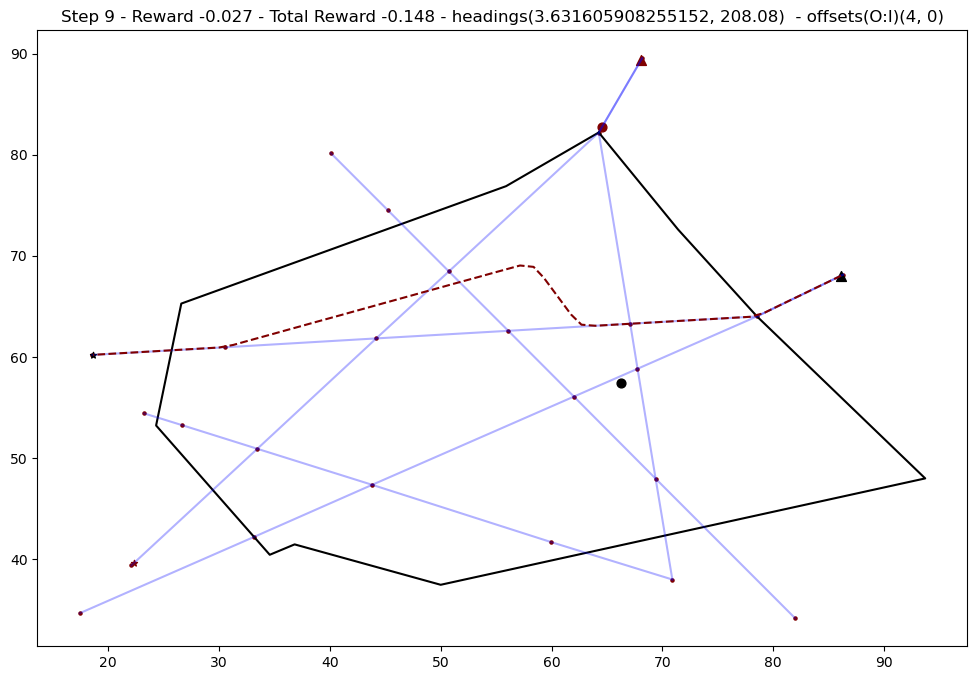

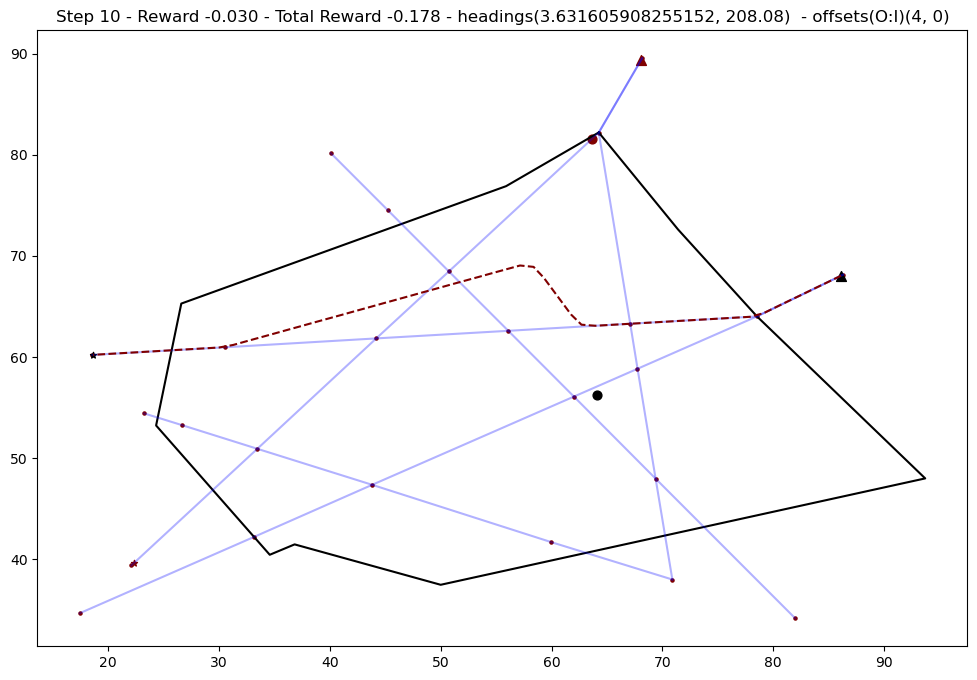

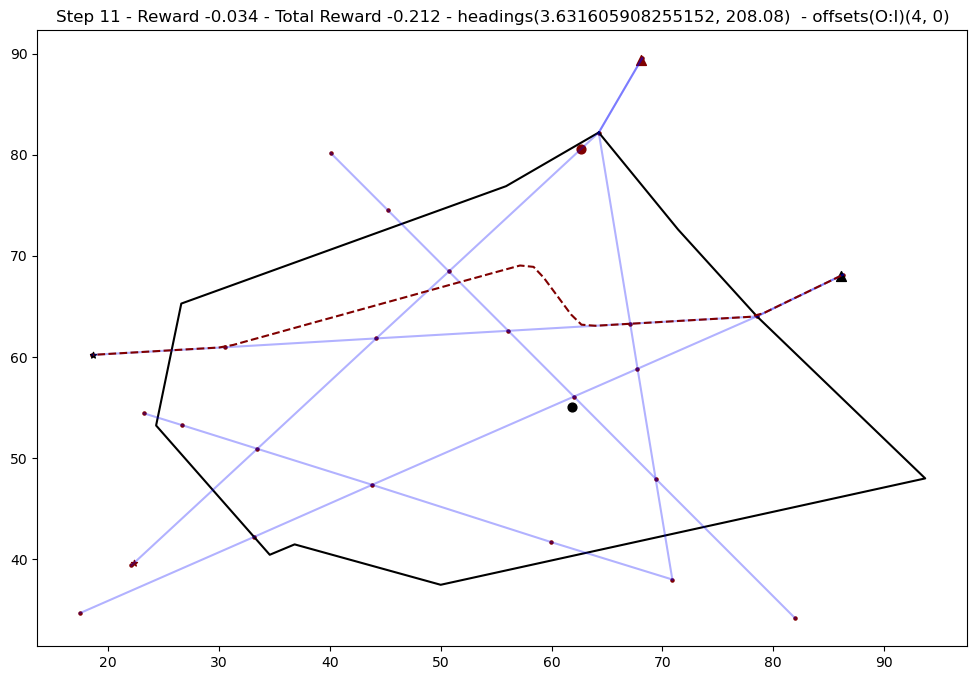

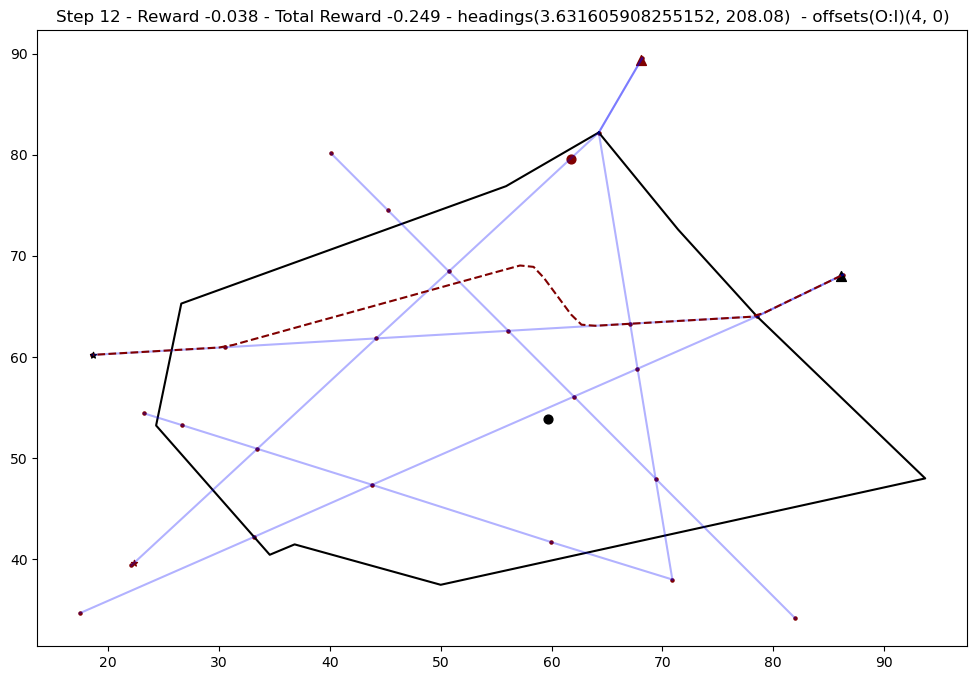

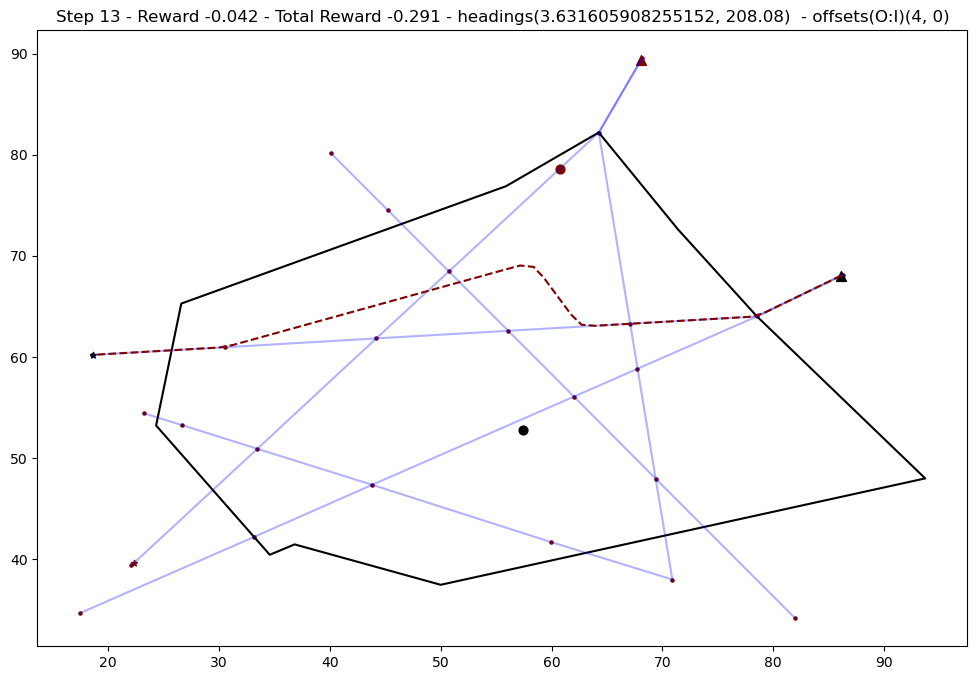

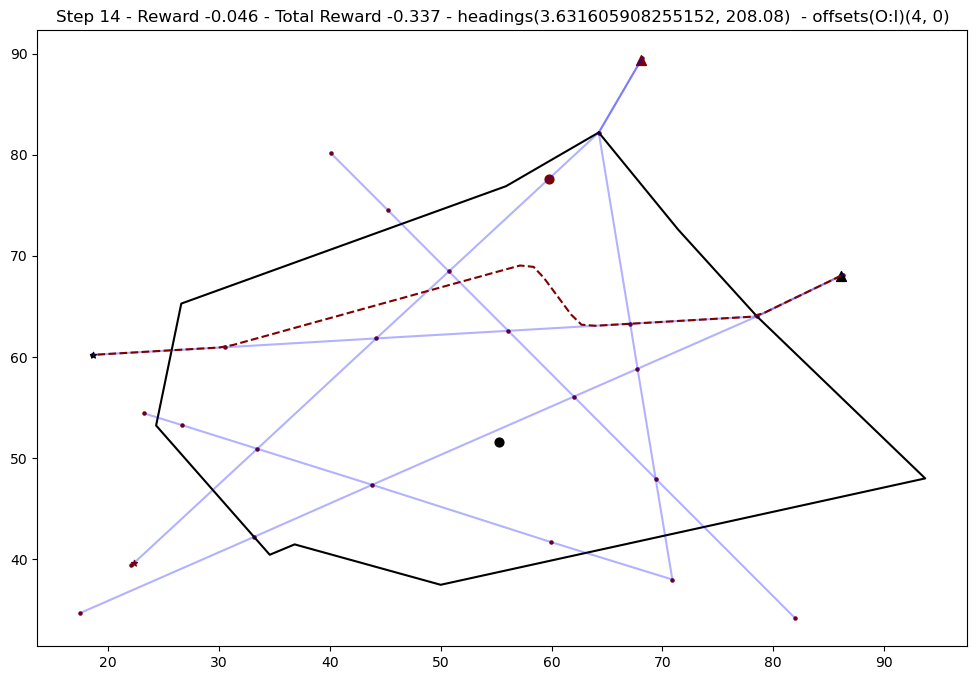

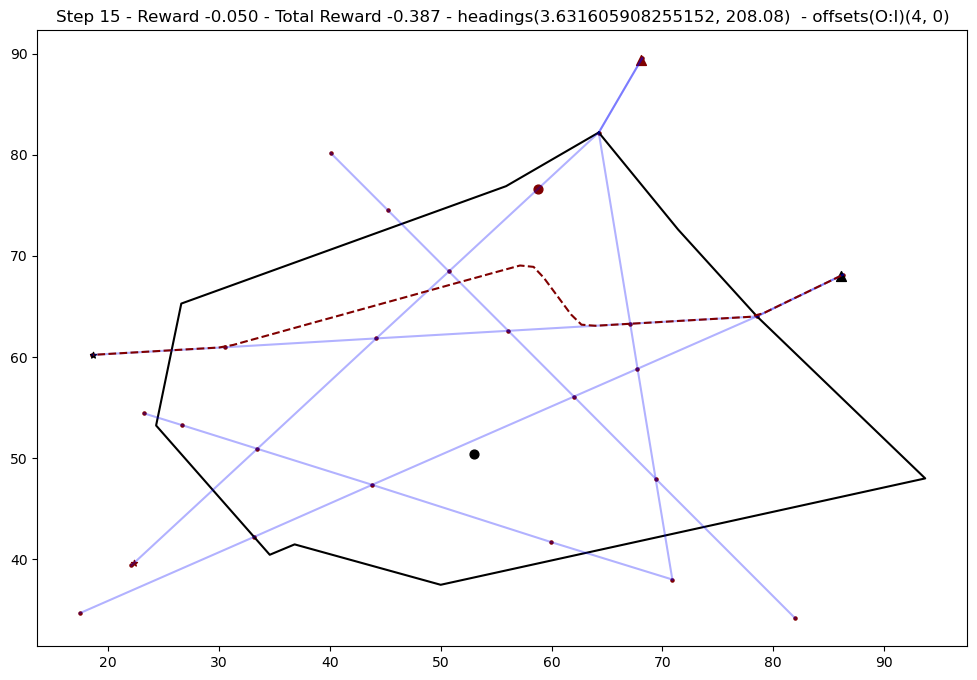

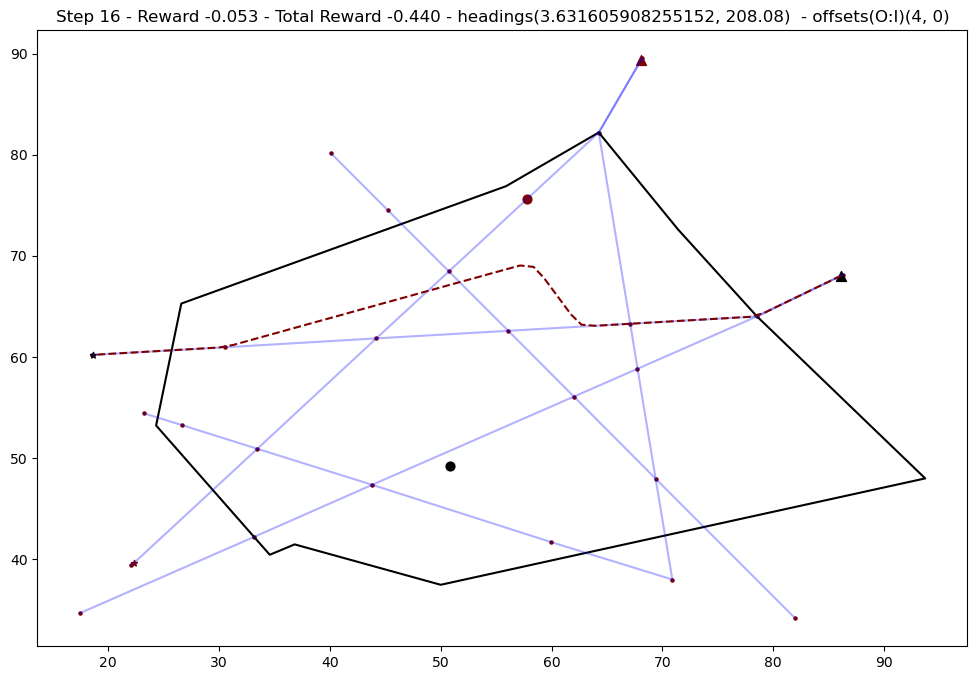

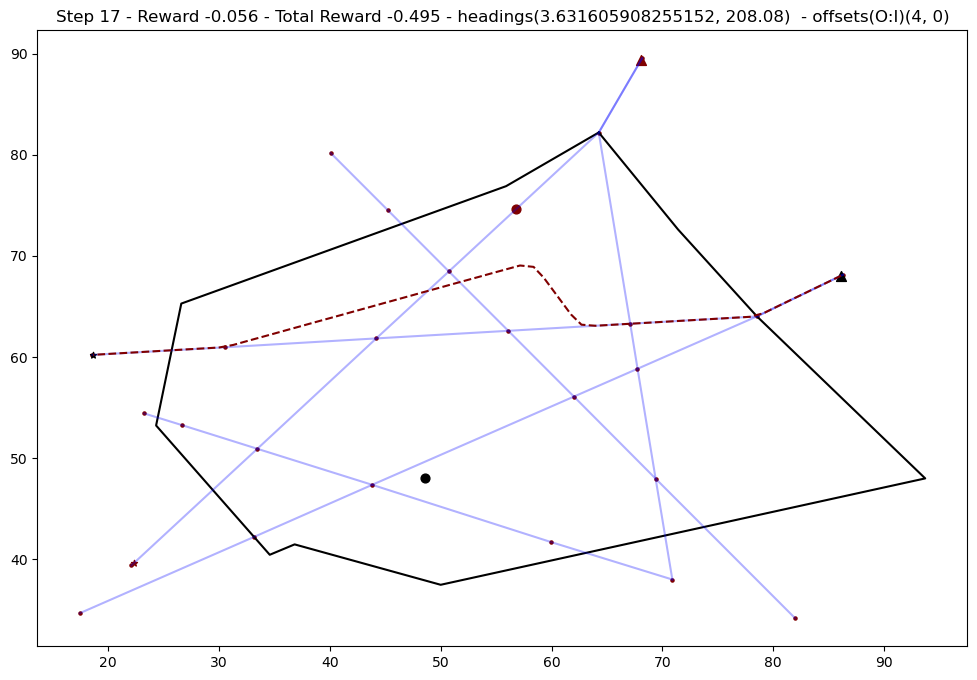

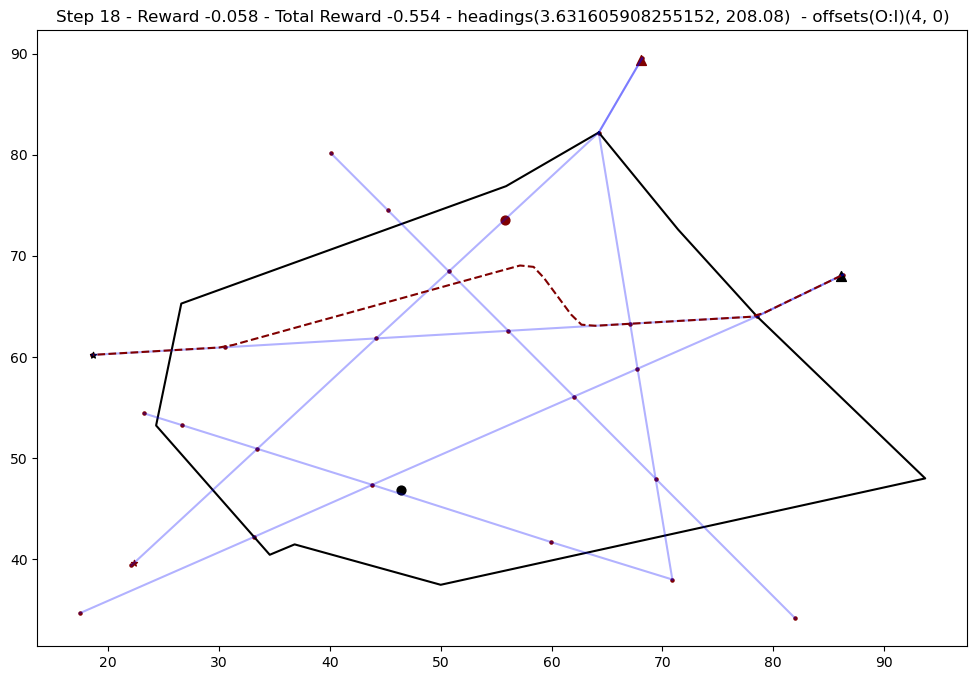

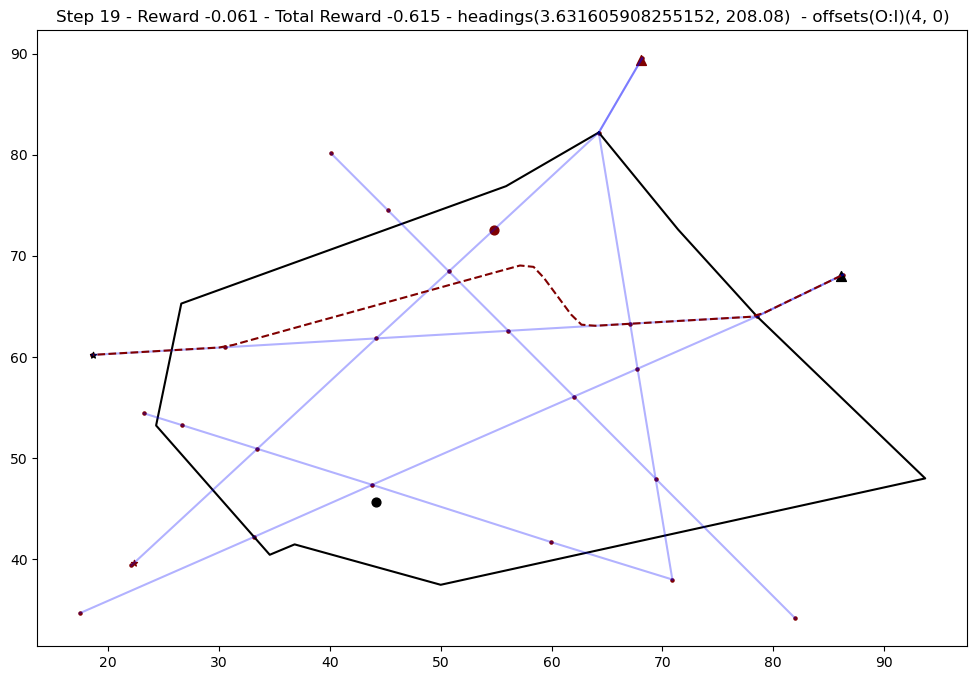

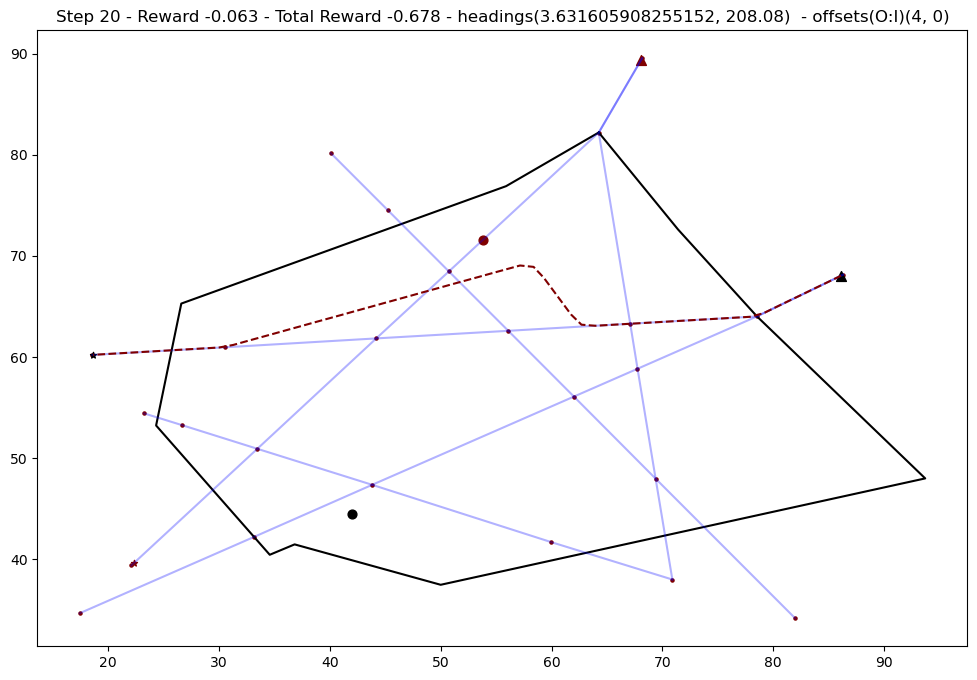

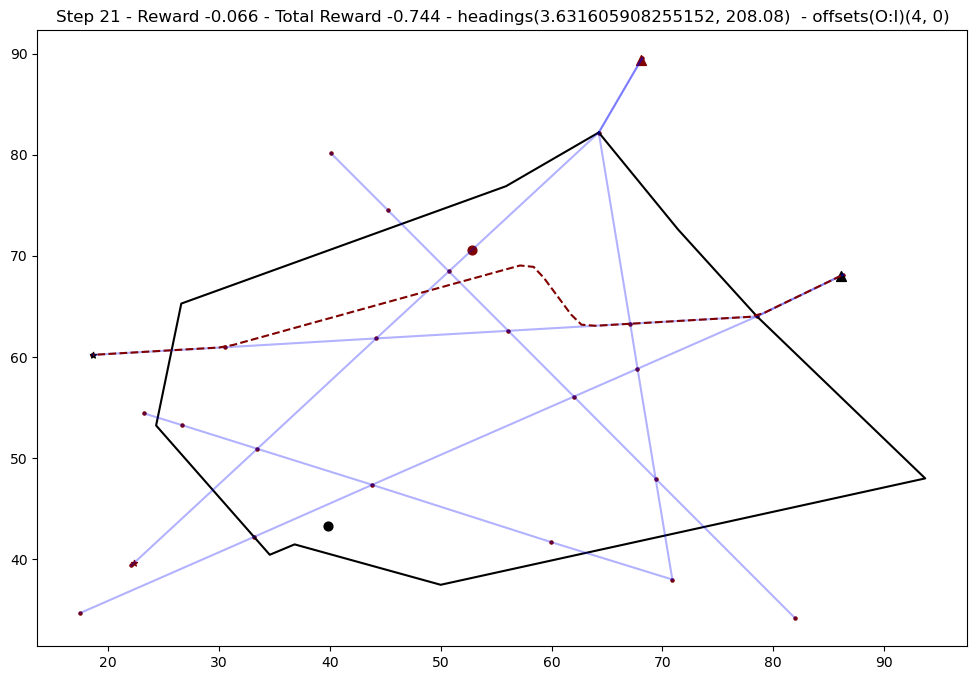

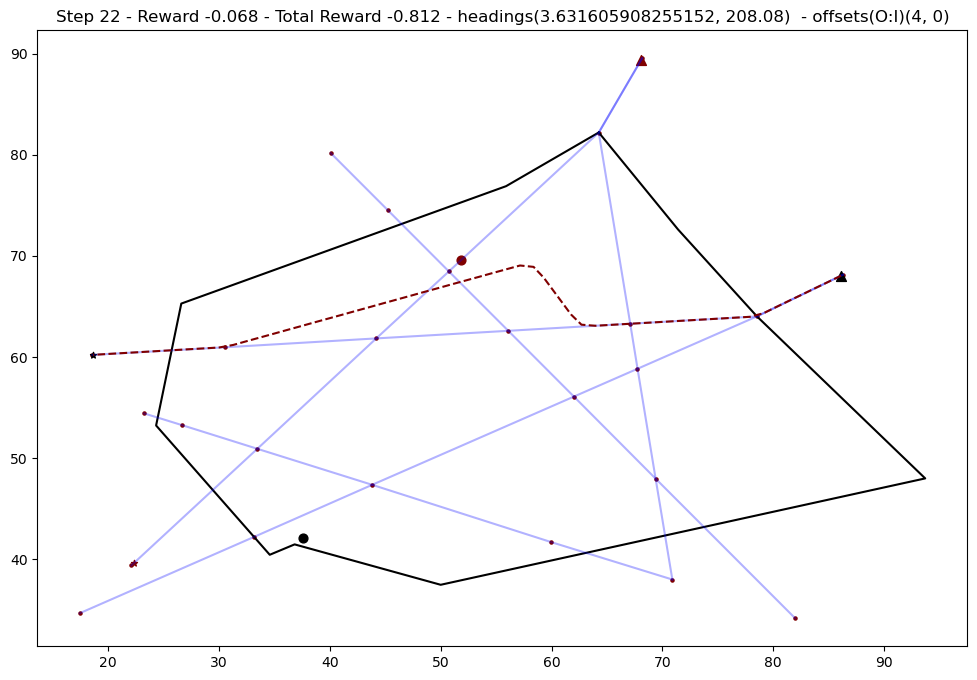

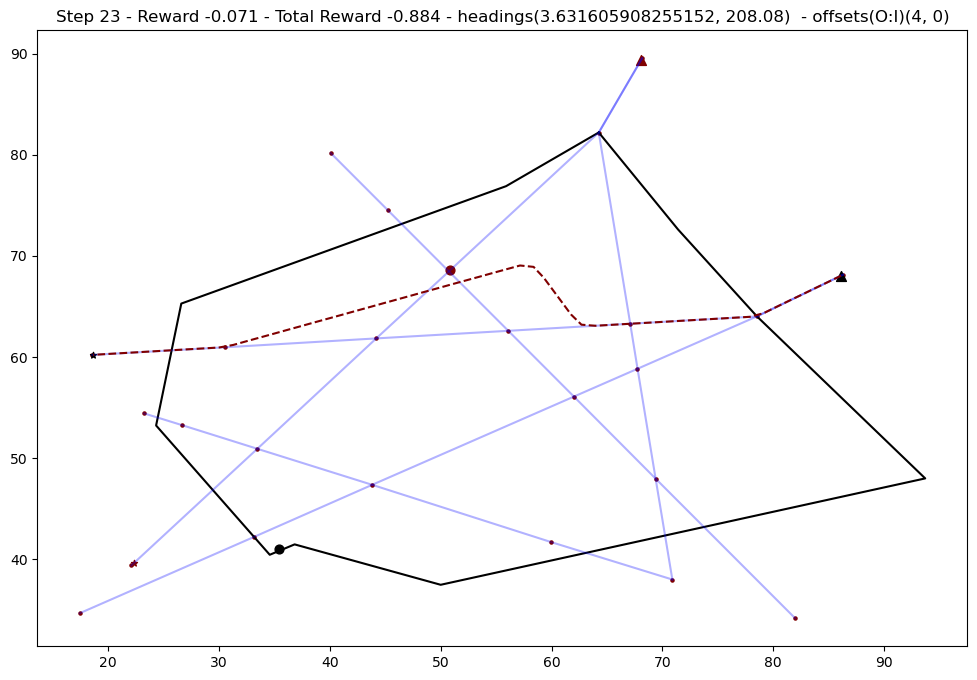

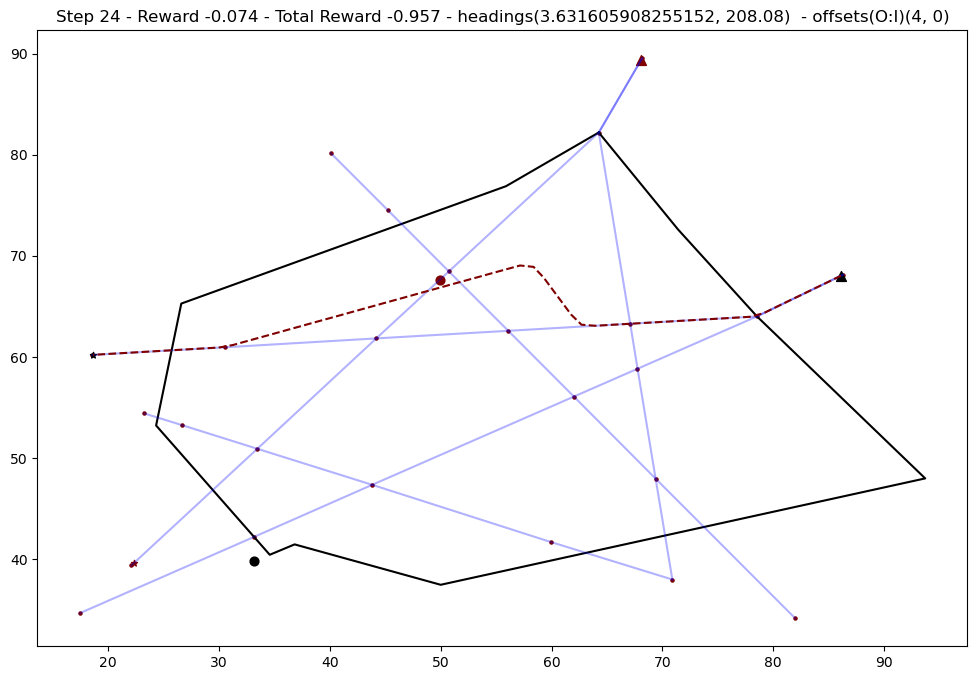

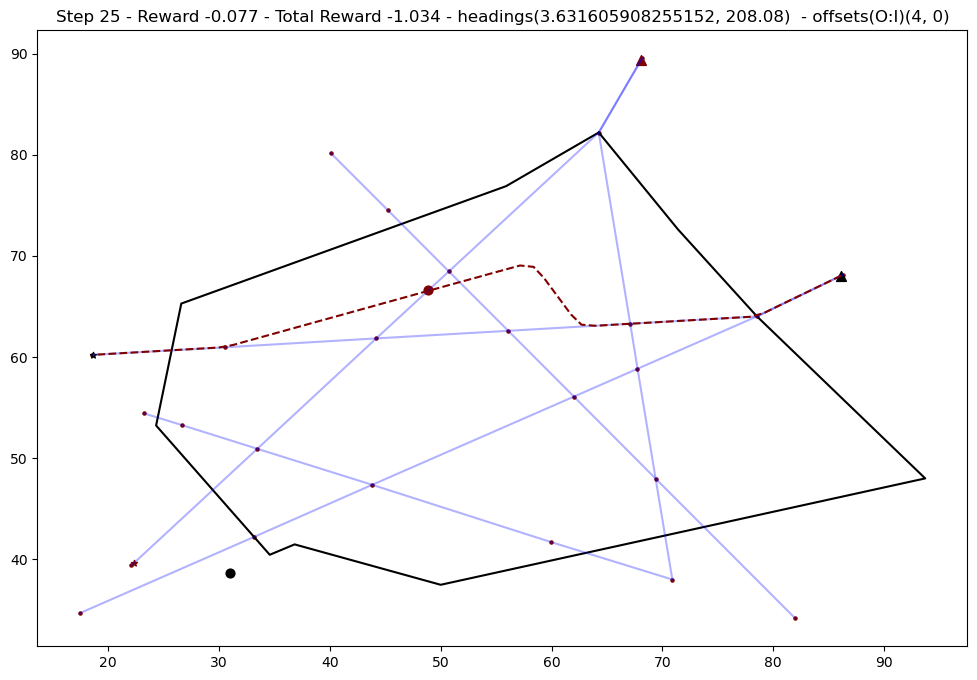

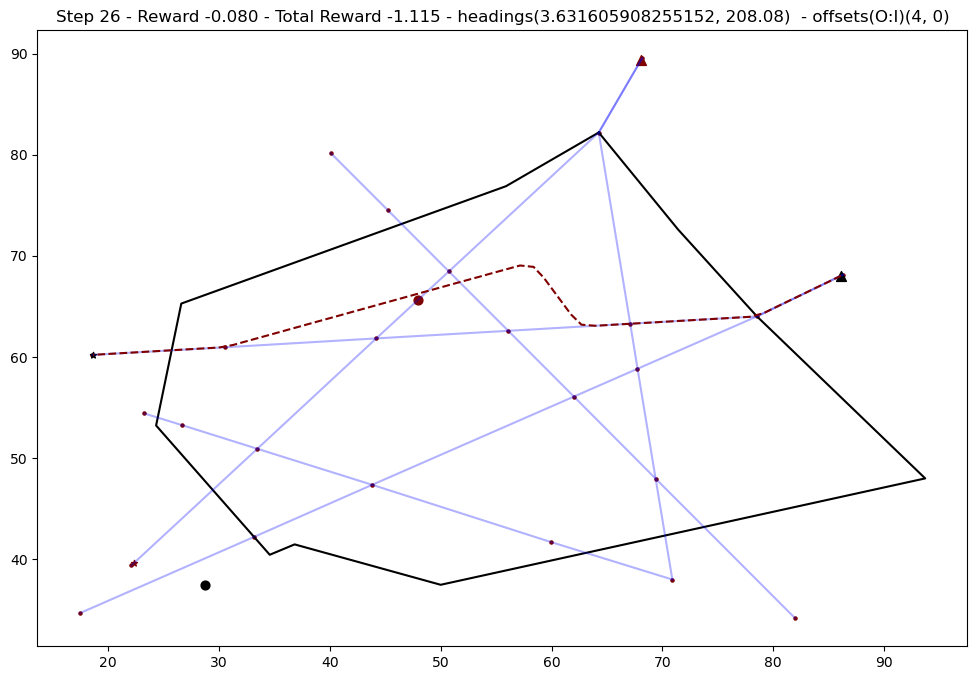

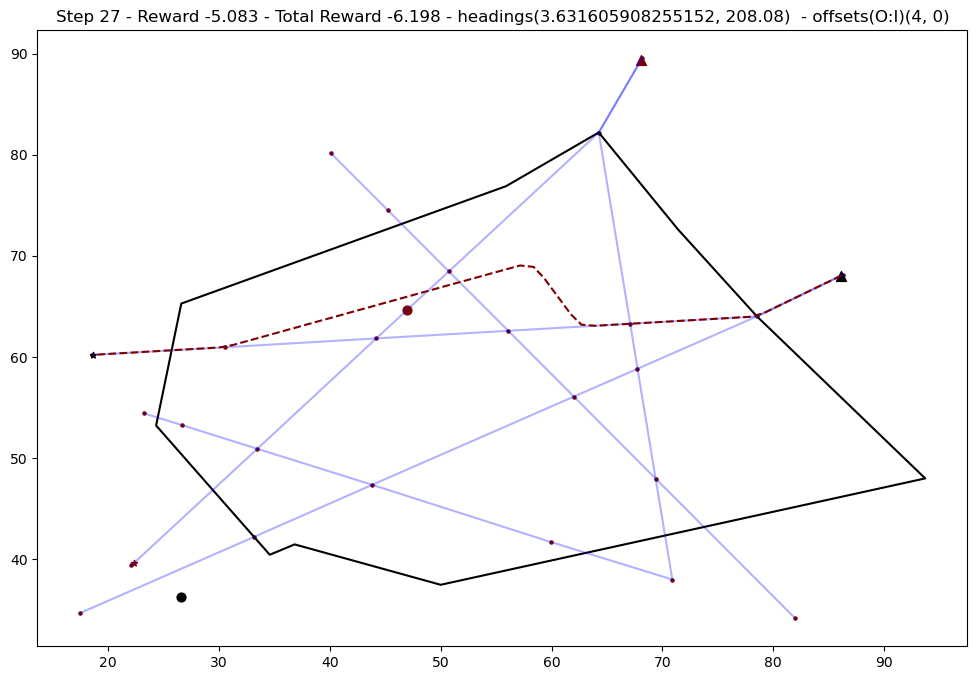

In [70]:
name = 'env_PPO_10july1'

env  = env
obs = env.reset()
for i in range(60):
    # Take a random action
    action, state_ = model.predict(obs, deterministic=True)
    action = 0
    obs, reward, done, info = env.step(action)
    
    # Render the game
    c = env.render(False,'./images2/')
    if done == True:
        break
        
# Generate the GIF from set of images        
# filepaths
fp_in = "./images2/image_*.png"
fp_out = "./images2/{}.gif".format(name)

imgs = []
for f in sorted(glob.glob(fp_in)):
    imgs.append(Image.open(f))
    os.remove(f)
    
img = imgs[0]  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=len(imgs)*10, loop=0)

In [62]:
# CHECKING THE PERCENTAGE OF SCENARIOS HAVING CONFLICTS
env = env
# Visualize 1 episode using the trained policy and store the image into selected folder
res = []
for trial in range(100):
    obs = env.reset()
    for i in range(60):
        # Take a random action
        action = 0
        obs, reward, done, info = env.step(action)
        
        # Render the game
        if done == True:
            if reward <= -10:
                res.append(1)
            else:
                res.append(0)
            break

res = np.mean(res)
print('res', res)

310321set2_1_3K171.csv 310321set2_1_QR170.csv
Offet distances 9.775002052753893 0.0
4 0
030321set1_1_3K81.csv 030321set1_1_SQ80.csv
Offet distances 0.0 1.8537987761196548
0 1
050421set2_1_SQ70.csv 050421set2_1_GA71.csv
YESSS
Offet distances 28.88121199277281 0.0
12 0
150321set1_1_PR261.csv 150321set1_1_QR260.csv
Offet distances 9.530627001435047 0.0
4 0
260321set1_1_GA281.csv 260321set1_1_TR280.csv
Offet distances 6.766073974696435 0.0
3 0
140521set1_1_3K181.csv 140521set1_1_SQ180.csv
Offet distances 6.224788056720721 0.0
3 0
170321set2_1_GA201.csv 170321set2_1_KL200.csv
Offet distances 10.508127206710435 0.0
5 0
190321set1_1_PR171.csv 190321set1_1_TR170.csv
Offet distances 11.97437751462352 0.0
5 0
310321set2_1_SQ80.csv 310321set2_1_KL81.csv
YESSS
Offet distances 26.858224993547147 0.0
11 0
050421set2_1_SQ231.csv 050421set2_1_3K230.csv
Offet distances 10.996877309348129 0.0
5 0
010321set2_1_SQ60.csv 010321set2_1_3K61.csv
YESSS
Offet distances 28.656435659525513 0.0
12 0
050421set1_1_G